# Testing the predictability of human-generated scary stories
## For this project, I decided to test the predictability of scary stories told on Reddit on r/TwoSentenceHorror. For each test, I have shown the number of upvotes the story has received, which is a rough measure of how well-liked it is. Then, I have plotted the probabilities of the words, and reported the average probability of all the words in the short story.
## I generate text for probability checking, token by token, starting 40% in.

## Initial Code

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2022-10-18 19:08:48.965551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 19:08:49.184526: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-18 19:08:49.962211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-18 19:08:49.962314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
model_name = 'gpt2'
# model_name = 'gpt2-xl'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [3]:
def gen_plot(input_txt):
    full_input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
    max_length = full_input_ids.shape[1]
    initial_size = int(max_length*0.4)

    tokens = []
    probs = []

    with torch.no_grad():
        for i in range(initial_size, max_length):
            input_ids = full_input_ids[0][0:i].unsqueeze(dim=0)
            goal = full_input_ids[0][i]

            output = model(input_ids=input_ids)

            # Select logits of the first batch and the last token and apply softmax to get the probability
            next_token_logits = output.logits[0, -1, :]
            next_token_probs = torch.softmax(next_token_logits, dim=-1)

            sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)

            if goal in sorted_ids:
                tokens.append(tokenizer.decode(goal))
                probs.append(next_token_probs[goal].cpu().numpy())
            else:
                print("ERROR: token not in list!")

    ax = plt.axes()
    plt.plot(probs)
    ax.set_xticks(range(0, len(tokens)))
    ax.set_xticklabels(tokens, fontsize=6)
    ax.set_xlabel("Token")
    ax.set_ylabel("Probability")
    ax.set_title("Average probability: " + str(round(np.mean(probs), 4)))
    plt.show()

## Tests on Reddit posts

### 1.   2,600 upvotes
#### This morning Daddy yelled at me for playing doctor, but I think he’s just grumpy since he’s had that cold. 
#### He started coughing as he crammed all my toys back under the sink and then he laid down on the floor for a nap, but I know he’ll wake up feeling better soon since I put all that medicine in his coffee.

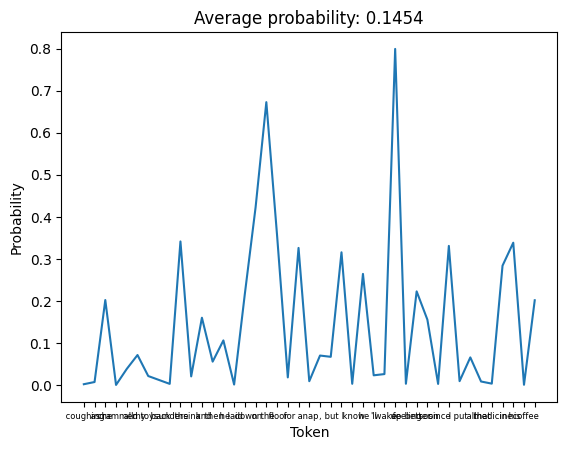

In [4]:
story = "This morning Daddy yelled at me for playing doctor, but I think he's just grumpy since he's had that cold.\n He started coughing as he crammed all my toys back under the sink and then he laid down on the floor for a nap, but I know he'll wake up feeling better soon since I put all that medicine in his coffee."
gen_plot(story)

### 2.   452 upvotes
#### We all have that one teacher, the one who had a major impact on our lives.
#### For me, that was old Mrs Smith, whose impact came at 85 miles per hour, head-on—into the car of Mr Edwards, who'd been abusing us for years.

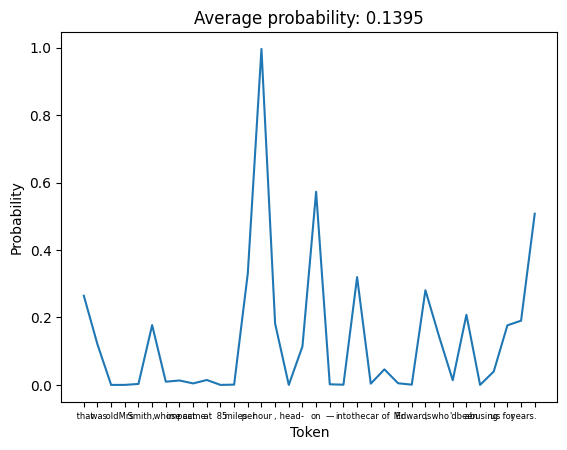

In [5]:
story = "We all have that one teacher, the one who had a major impact on our lives.\n For me, that was old Mrs Smith, whose impact came at 85 miles per hour, head-on—into the car of Mr Edwards, who'd been abusing us for years."
gen_plot(story)

### 3.   205 upvotes
#### I watched in horror as the woman screamed while getting her nose pierced.
#### God, I really need to get better at darts.

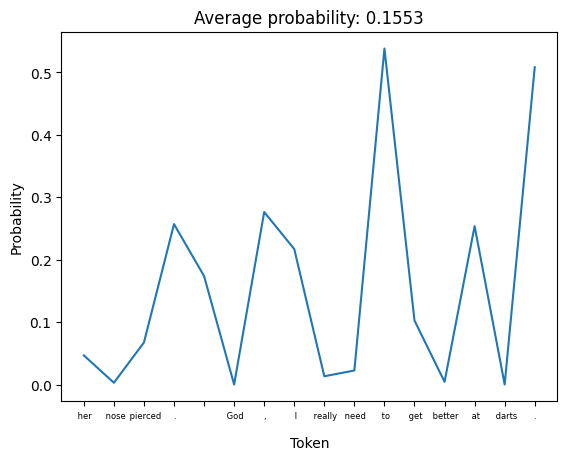

In [6]:
story = "I watched in horror as the woman screamed while getting her nose pierced.\n God, I really need to get better at darts."
gen_plot(story)

### 4.   6700 upvotes
#### "D-d-does your daughter want a pony?" the stable master asked, backing away from me.
#### "No," I said, starting the chainsaw, "what she wants is a centaur."

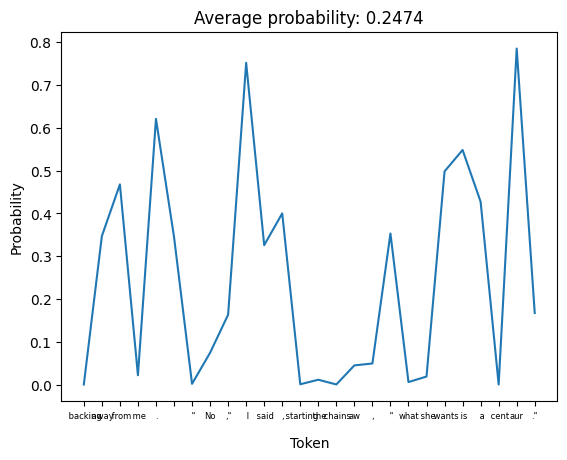

In [7]:
story = '"D-d-does your daughter want a pony?" the stable master asked, backing away from me.\n "No," I said, starting the chainsaw, "what she wants is a centaur."'
gen_plot(story)

### 5.   1900 upvotes
#### When we set out for our camping trip I told my son “NEVER answer voices calling your name in the woods…”
#### Three days after getting separated, our search party still hasn’t found him.

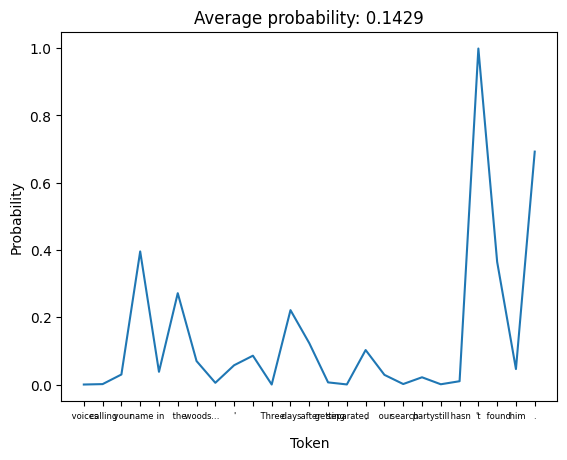

In [8]:
story = "When we set out for our camping trip I told my son 'NEVER answer voices calling your name in the woods…'\n Three days after getting separated, our search party still hasn't found him."
gen_plot(story)